In [83]:
import numpy as np
from itertools import product

class SPIModel(object):
    '''
       SPI model based on Experiment 2 KTH, SR, AM SPI Mechanism
    
    '''
    def __init__(self, **kwargs):
        
        self.numPlayers = 2
        self.value = np.array([200, 250, 320])
        self.cost = np.array([130, 80, 10])
            
        
        # number of individual actions
        self.numiActions = 12
        self.buyerActions = np.array([[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],
                                      [1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1],
                                       [2, 0, 0],[2, 0, 1],[2, 1, 0],[2, 1, 1]])
        self.sellerActions = np.array([[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],
                                      [1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1],
                                       [2, 0, 0],[2, 0, 1],[2, 1, 0],[2, 1, 1]])
        
        self.memory = kwargs.get('memory', 0)
        self.true_value_index = kwargs.get('true_value',2)
        self.true_cost_index = kwargs.get('true_cost',2)
        self.trueValue = self.value[self.true_value_index]
        self.trueCost = self.cost[self.true_cost_index]
        
        self.buyerInvestment = 0
        self.sellerInvestment = 0       
#         self.trueValue = self.init_TrueValue(self.sellerInvestment)
#         self.trueCost = self.init_TrueCost(self.buyerInvestment)
        
        
        self.numActions = self.numiActions ** self.numPlayers
        self.numStates = self.numiActions ** (self.numPlayers * self.memory)
        
        self.indexActions = self.init_indexActions()
        self.Prices = self.init_Prices()
        self.Profits,self.Penalty = self.init_Profits()

        # QL
        self.delta = kwargs.get('delta', 0.95)
        self.alpha = kwargs.get('alpha', 0.15) * np.ones(self.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.numPlayers)
        
        self.lengthStates = self.numPlayers * self.memory
        self.lengthStrategies = self.numPlayers * self.numStates
        
        self.Q = self.init_Q()

        self.cActions = self.init_cActions()
        
        
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    def init_TrueValue(self, i):
        if i == 0:
            return 200
        elif i == 25:
            return 250
        else:
            return 320

    def init_TrueCost(self, i):
        if i == 0:
            return 130
        elif i == 25:
            return 80
        else:
            return 10
    
    def init_Prices(self):
        
        pricesArray = np.zeros((3, 3))
        for cb in range(0, 3):
            for vs in range(0, 3):
                
                # (vs-200) - (130-cb) + 165
                
                pricesArray[cb][vs] = (self.value[vs] - 200) - (130 - self.cost[cb]) + 165
                
        return pricesArray

    

    def init_Profits(self):
        Profits = np.zeros((self.numActions, self.numPlayers))

        Actions = np.zeros((self.numActions, 6))

        Penalty = np.zeros((self.numActions, self.numPlayers))
        
        for i in range(self.numActions):
            
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            vb, first_b, second_b = self.buyerActions[b]
            cs, first_s, second_s = self.sellerActions[s]
            penals = 0
            penalb = 0
            
            Actions[i] = vb, first_b, second_b, cs, first_s, second_s

            
            # if into arbitration
            if second_b == 0 and second_s == 1:
                # no_trade
                pb = - self.buyerInvestment
                ps = - self.sellerInvestment
                if first_s == 0:
                    penalb = -300
                    penals = -300
                else:
                    penalb = 300
                    penals = -300
                
                
            elif second_s == 0:
                # no_trade
                pb = - self.buyerInvestment
                ps = - self.sellerInvestment
                penalb = 0
                penals = 0
                
            else:
                if first_b == 0 and first_s == 0:
                    pb = self.trueValue - (self.Prices[cb][vs] + 15) - self.buyerInvestment - 5
                    ps = (self.Prices[cb][vs] - 15) - self.trueCost - self.sellerInvestment - 5
                    penalb = 0
                    penals = 0  
                    
                elif first_b == 0 and first_s == 1:
                    pb = self.trueValue - (self.Prices[cb][vs]) - self.buyerInvestment - 5
                    ps = (self.Prices[cb][vs] - 15) - self.trueCost - self.sellerInvestment
                    penalb = 0
                    penals = 0                     
                elif first_b == 1 and first_s == 0:
                    pb = self.trueValue - (self.Prices[cb][vs] + 15) - self.buyerInvestment
                    ps = (self.Prices[cb][vs]) - self.trueCost - self.sellerInvestment - 5
                    penalb = 0
                    penals = 0 
                else:
                    pb = self.trueValue - (self.Prices[cb][vs]) - self.buyerInvestment
                    ps = (self.Prices[cb][vs]) - self.trueCost - self.sellerInvestment
                    penalb = 0
                    penals = 0                     
                     

            Profits[i] = [pb, ps]
            Penalty[i] = [penalb,penals]

        return Profits,Penalty

    
    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array(self.Profits,
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q


    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



    

In [76]:
spi = SPIModel()
spi.Q

array([[[   0.        ,    0.        ],
        [ 848.33333333,  848.33333333],
        [   0.        ,    0.        ],
        ...,
        [2048.33333333, 2048.33333333],
        [   0.        ,    0.        ],
        [2108.33333333, 2108.33333333]],

       [[   0.        ,    0.        ],
        [ 848.33333333,  848.33333333],
        [   0.        ,    0.        ],
        ...,
        [2048.33333333, 2048.33333333],
        [   0.        ,    0.        ],
        [2108.33333333, 2108.33333333]],

       [[   0.        ,    0.        ],
        [ 848.33333333,  848.33333333],
        [   0.        ,    0.        ],
        ...,
        [2048.33333333, 2048.33333333],
        [   0.        ,    0.        ],
        [2108.33333333, 2108.33333333]],

       ...,

       [[   0.        ,    0.        ],
        [ 848.33333333,  848.33333333],
        [   0.        ,    0.        ],
        ...,
        [2048.33333333, 2048.33333333],
        [   0.        ,    0.        ],
        [

In [86]:
import numpy as np

# from SPIModel import SPIModel

    
class SPI_Qlearning(object):
    '''
        Qlearning based on SPI model
    '''
    def __init__(self, **kwargs):
        
        self.alpha = kwargs.get('alpha',0.25)
        self.beta = kwargs.get('beta',0.05)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',50)
        self.maxIters = kwargs.get('maxIters',100000)
        self.game = SPIModel(alpha = self.alpha, beta = self.beta)
        self.initial_state = kwargs.get('initial_state',0)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.game.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):
        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))

        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        
        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            initialAction = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   
            strategyPrime = initialAction
            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter

                # Compute pPrime by balancing exploration vs. exploitation

                pPrime = self.computePPrime(strategyPrime, iters)
                #pPrime = strategyPrime
                actionPrime = int(np.sum(self.game.cActions*pPrime)) 

                state = actionPrime
                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    
                    maxVal[iPlayer] = np.max(temp_q)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
                    
                    # Q matrices and strategies update
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                        
                    newq = oldq + self.game.alpha[iPlayer] * (self.game.Profits[state, iPlayer] + \
                                                self.game.delta * maxVal[iPlayer] - oldq)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                    self.profit_list[iSession,iters,iPlayer] = self.game.Profits[state,iPlayer]
                    self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[state,iPlayer]

                # Assessing convergence
                if np.array_equiv(strategyPrime, pPrime):
                    itersInStrategy = itersInStrategy + 1
                
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [87]:
K = SPI_Qlearning()
K.q_learning()

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1


(array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.],
        [603., 582., 590., 576., 572., 561., 605., 568., 554., 568., 566.,
         603., 631., 577., 617., 626., 579., 584., 579., 556., 580., 593.,
         540., 574., 582., 624., 553., 568., 573., 559., 551., 582., 640.,
         573., 548., 584., 600., 571., 566., 645., 577., 596., 577., 572.,
         570., 571., 572., 573., 591., 683.]]),
 array([[11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.],
        [11., 11., 

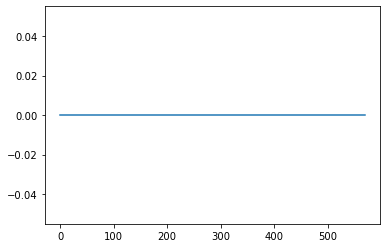

In [47]:
import matplotlib.pyplot as plt
plt.plot(K.penalty_list[0,:,0].cumsum())

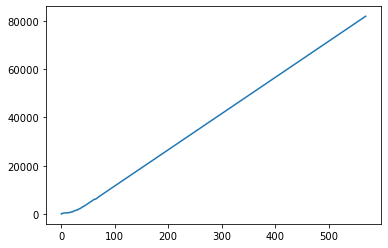

In [49]:
import matplotlib.pyplot as plt
plt.plot(K.profit_list[0,:,1].cumsum())

In [102]:
np.sum(K.penalty_list[0,:int(K.indexConverge[1,0]),0]!=0)/ \
    (np.sum(~np.isnan(K.penalty_list[0,:int(K.indexConverge[1,0]),0]))-500)

0.009523809523809525

In [53]:
np.sum(~np.isnan(K.penalty_list))

46328

In [23]:
from multiprocessing import Pool

def single_process(alpha):

    converge_list = [10000]
    beta_list = [0.0005]
    for cl in converge_list:
        df = pd.DataFrame(columns=['alpha','beta','total_sessions',
                                   'converged_times','i ndexStrategie','indexConverge'])
        path = 'SR_parallel_result'
        if not os.path.exists(path):
            os.mkdir(path)

        for beta in beta_list:
            temp_model = SPI_Qlearning(alpha = alpha,beta = beta, convergedtime = cl)
            temo_model.q_learning()
            indexConverge,indexStrategies = q_learning()
            df = df.append({'alpha':alpha,'beta':beta,'total_sessions':kth.numSessions,
                            'converged_times':cl,'indexStrategie':indexStrategies,
                            'indexConverge':indexConverge },ignore_index=True)
            print('alpha:',alpha,' beta:',beta,' converged_times:',cl,' finish!')

        with open(path + '/' + 'a_'+ str(alpha) + 'b_'+ str(beta) + '_cl_' + str(cl) + '.pkl', 'wb') as f:
            pickle.dump(df, f)

def run_complex_operations(operation, input, pool):
    pool.map(operation, input)



In [24]:
processes_count = 10
     

alpha_list = np.linspace(0.025,0.25,2)
processes_pool = Pool(processes_count)
run_complex_operations(single_process,alpha_list , processes_pool)

Process SpawnPoolWorker-24:
Process SpawnPoolWorker-23:
Traceback (most recent call last):
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
AttributeError: Can't get attribute 'single_process' on <module '__main__' (built-in)>
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

KeyboardInterrupt: 

python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-29:
Traceback (most recent call last):
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last